In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import mglearn
import matplotlib.pyplot as plt
import torch
import spacy

from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

from sklearn.model_selection import GridSearchCV

In [2]:
data = pd.read_csv('Restaurant_Reviews.tsv',delimiter = '\t', quoting = 3)

In [3]:
data.head()

,Review,Liked
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1


In [4]:
#Count liked/disliked. Recall, like = 1.

print(data['Liked'].value_counts())

1    500
0    500
Name: Liked, dtype: int64


In [5]:
#Set test/train models.

text_train, text_test, y_train, y_test = train_test_split(data['Review'], data['Liked'], test_size=0.3, random_state=111)

In [6]:
print("type of text_train: {}".format(type(text_train)))
print("length of text_train: {}".format(len(text_train)))

type of text_train: <class 'pandas.core.series.Series'>
length of text_train: 700


In [7]:
print("Samples per class (training): {}".format(np.bincount(y_train)))

Samples per class (training): [349 351]


# Bag-of-words

In [8]:
from sklearn.feature_extraction.text import CountVectorizer

In [9]:
vect = CountVectorizer()
vect.fit(text_train)
X_train = vect.transform(text_train)
X_test = vect.transform(text_test)

print("X_train:\n{}".format(repr(X_train)))

print("X_test:\n{}".format(repr(X_train)))

X_train:
<700x1664 sparse matrix of type '<class 'numpy.int64'>'
	with 6823 stored elements in Compressed Sparse Row format>
X_test:
<700x1664 sparse matrix of type '<class 'numpy.int64'>'
	with 6823 stored elements in Compressed Sparse Row format>


In [10]:
#Above tells us vocab has 1664 distinct entries. We can be more direct with this count.

feature_names = vect.get_feature_names_out()

print("Number of features: {}".format(len(feature_names)))

print("Every 100th feature.:\n{}".format(feature_names[::100]))


Number of features: 1664
Every 100th feature.:
['10' 'awful' 'bruschetta' 'conclusion' 'dinners' 'everyone' 'fucking'
 'hello' 'large' 'menus' 'options' 'pop' 'rice' 'simple' 'suggestions'
 'trap' 'well']


### Logistic Regression

In [11]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}
grid = GridSearchCV(LogisticRegression(), param_grid, cv=5)
grid.fit(X_train, y_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters: ", grid.best_params_)
print("{:.2f}".format(grid.score(X_test, y_test)))

Best cross-validation score: 0.77
Best parameters:  {'C': 1}
0.81


In [12]:
model = LogisticRegression(random_state=111, solver='liblinear').fit(X_train, y_train)
y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print('Accuracy: ' + str(acc))
print('')
print('Classification Report:')
print(classification_report(y_test, y_pred, labels=[0, 1]))

Accuracy: 0.8066666666666666

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.81      0.81       151
           1       0.81      0.80      0.80       149

    accuracy                           0.81       300
   macro avg       0.81      0.81      0.81       300
weighted avg       0.81      0.81      0.81       300



In [13]:
# Let us redo, but now consider tokens that appear in at least two distinct reviews to avoid unique words/overfit.

vect = CountVectorizer(min_df=2).fit(text_train)
X_train = vect.transform(text_train)
feature_names = vect.get_feature_names_out()

print("X_train with min_df: {}".format(repr(X_train)))
print("")
print("Every 100th feature.:\n{}".format(feature_names[::100]))

X_train with min_df: <700x676 sparse matrix of type '<class 'numpy.int64'>'
	with 5835 stored elements in Compressed Sparse Row format>

Every 100th feature.:
['10' 'butter' 'expected' 'inside' 'only' 'see' 'totally']


In [14]:
grid = GridSearchCV(LogisticRegression(), param_grid, cv=2)
grid.fit(X_train, y_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))

Best cross-validation score: 0.74


In [15]:
# Score is worse, reasonable considering dataset size. TF-IDF may do better. 

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline

pipe = make_pipeline(TfidfVectorizer(norm=None),
 LogisticRegression())
param_grid = {'logisticregression__C': [0.001, 0.01, 0.1, 1, 10]}
grid = GridSearchCV(pipe, param_grid)
grid.fit(text_train, y_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))

Best cross-validation score: 0.78


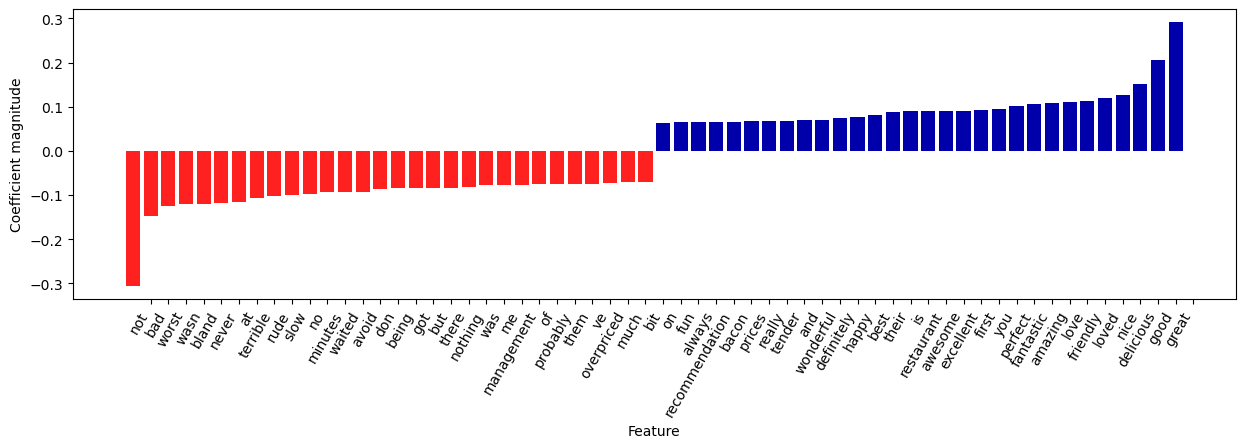

In [16]:
vectorizer = grid.best_estimator_.named_steps["tfidfvectorizer"]
# transform the training dataset

X_train = vectorizer.transform(text_train)
# find maximum value for each of the features over the dataset

max_value = X_train.max(axis=0).toarray().ravel()
sorted_by_tfidf = max_value.argsort()
# get feature names

feature_names = np.array(vectorizer.get_feature_names_out())

mglearn.tools.visualize_coefficients(grid.best_estimator_.named_steps["logisticregression"].coef_,
                                     feature_names, n_top_features=30)

# Bigrams

In [17]:
bivect = CountVectorizer(ngram_range=(2, 2)).fit(text_train)

print("Vocabulary size: {}".format(len(bivect.vocabulary_)))

print("Vocabulary:\n{}".format(bivect.get_feature_names()))


Vocabulary size: 4899
Vocabulary:
['10 minutes', '10 times', '100 times', '11 99', '12 ridiculous', '17 burger', '1979 and', '20 minutes', '23 which', '30 min', '30 minutes', '30s and', '35 big', '35 minutes', '40 and', '40 bucks', '40 minutes', '40min passed', '45 minutes', '4ths gristle', '5lb piece', '70 when', '90 has', '99 for', 'about great', 'about half', 'about here', 'about on', 'about our', 'about taste', 'about the', 'about this', 'about was', 'about working', 'above and', 'above average', 'absolute must', 'absolutely amazing', 'absolutely be', 'absolutely delicious', 'absolutely no', 'absolutely stars', 'absolutley fantastic', 'accident and', 'accommodations for', 'accomodate for', 'acknowledged then', 'actually rare', 'added gratuity', 'affordable prices', 'after 10', 'after 20', 'after one', 'after some', 'after us', 'again because', 'ago and', 'ahead of', 'airline food', 'all am', 'all and', 'all are', 'all cost', 'all day', 'all good', 'all ha', 'all had', 'all handmade

C:\Users\Owner\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [18]:
pipe = make_pipeline(TfidfVectorizer(), LogisticRegression())
param_grid = {"logisticregression__C": [0.001, 0.01, 0.1, 1, 10, 100],
 "tfidfvectorizer__ngram_range": [(1, 1), (1, 2), (2, 2)]}

grid = GridSearchCV(pipe, param_grid)
grid.fit(text_train, y_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters:\n{}".format(grid.best_params_))

Best cross-validation score: 0.78
Best parameters:
{'logisticregression__C': 100, 'tfidfvectorizer__ngram_range': (1, 2)}


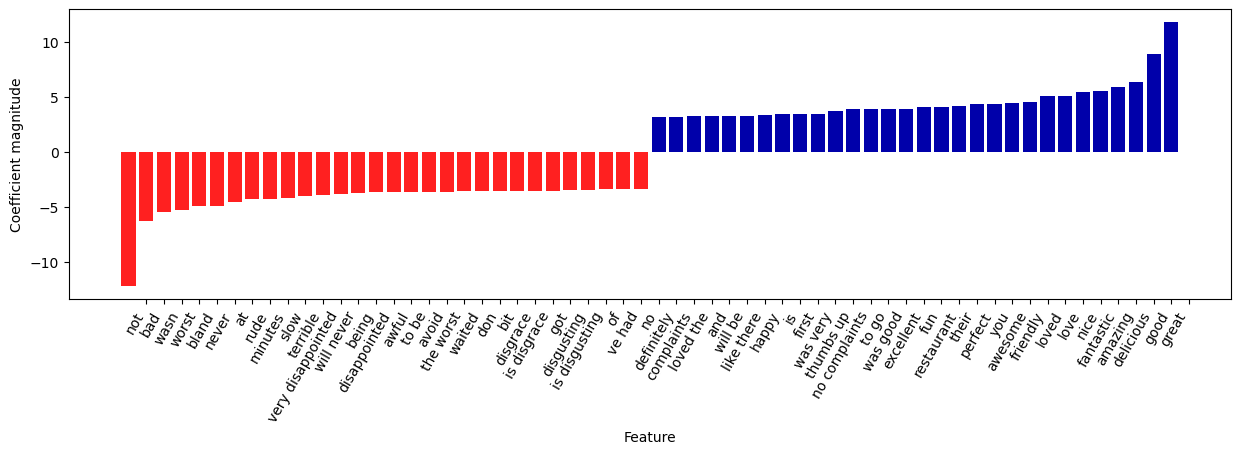

In [19]:
vectorizer = grid.best_estimator_.named_steps["tfidfvectorizer"]

feature_names = np.array(vectorizer.get_feature_names_out())

mglearn.tools.visualize_coefficients(grid.best_estimator_.named_steps["logisticregression"].coef_,
                                     feature_names, n_top_features=30)

# Latent Dirichlet Allocation

In [20]:
# We try LDA to see if some restaurant features can be reasonably grouped together.
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_components=10, learning_method="batch", 
                                max_iter=25, random_state=111)

vect = CountVectorizer()

X_train = vect.fit_transform(text_train)

document_topics = lda.fit_transform(X_train)

lda.components_.shape

(10, 1664)

In [21]:
sorting = np.argsort(lda.components_, axis=1)[:, ::-1]

feature_names = np.array(vect.get_feature_names_out())

mglearn.tools.print_topics(topics=range(10), feature_names=feature_names, 
                           sorting=sorting, topics_per_chunk=5, n_words=10)

topic 0       topic 1       topic 2       topic 3       topic 4       
--------      --------      --------      --------      --------      
is            to            to            the           the           
the           not           place         was           and           
and           our           this          good          to            
there         great         back          very          food          
was           was           and           and           was           
this          and           be            we            is            
place         go            it            were          that          
service       the           the           service       with          
nothing       will          not           in            they          
special       again         is            food          for           


topic 5       topic 6       topic 7       topic 8       topic 9       
--------      --------      --------      --------      --------      
the 